# Find Images that are most similar to each other

In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import urllib.request
import tarfile

class ImageNetteDistanceAnalyzer:
    def __init__(self, data_dir='./data', split='train', image_size=(256, 256)):
        self.data_dir = Path(data_dir)
        self.split = split
        self.image_size = image_size
        
        # Transform for feature extraction
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])
        
        self.dataset = None
        self.features = []
        self.image_paths = []
        self.labels = []
        
    def download_and_load_imagenette(self):
        """Download and load ImageNette dataset using torchvision"""
        print("Setting up ImageNette dataset...")
        
        # Create data directory
        self.data_dir.mkdir(exist_ok=True)
        
        # Download ImageNette if not exists
        imagenette_path = self.data_dir / 'imagenette2'
        
        if not imagenette_path.exists():
            print("Downloading ImageNette dataset...")
            
            url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
            tar_path = self.data_dir / 'imagenette2.tgz'
            
            urllib.request.urlretrieve(url, tar_path)
            
            with tarfile.open(tar_path, 'r:gz') as tar:
                tar.extractall(self.data_dir)
            
            # Clean up tar file
            tar_path.unlink()
            print("Download complete!")
        
        # Load dataset using ImageFolder
        dataset_path = imagenette_path / self.split
        self.dataset = ImageFolder(
            root=dataset_path,
            transform=self.transform
        )
        
        # Extract paths and labels
        self.image_paths = [Path(path) for path, _ in self.dataset.samples]
        self.labels = [label for _, label in self.dataset.samples]
        
        print(f"Loaded {len(self.dataset)} images from {dataset_path}")
        print(f"Classes: {self.dataset.classes}")
        
        return self.dataset
    
    def extract_features(self):
        """Extract flattened pixel features from all images"""
        print("Extracting features from images...")
        
        # Use DataLoader for efficient batch processing
        dataloader = torch.utils.data.DataLoader(
            self.dataset, 
            batch_size=32, 
            shuffle=False, 
            num_workers=2  # Reduced for notebook stability
        )
        
        self.features = []
        
        with torch.no_grad():
            for batch_idx, (images, _) in enumerate(tqdm(dataloader, desc="Processing batches")):
                # Flatten images to 1D vectors for L2 distance calculation
                batch_features = images.view(images.size(0), -1).numpy()
                self.features.extend(batch_features)
        
        self.features = np.array(self.features)
        print(f"Feature matrix shape: {self.features.shape}")
        
    def find_closest_pairs(self, top_k=10, same_class_only=False):
        """Find the top k closest image pairs using L2 distance"""
        print("Computing pairwise L2 distances...")
        
        # Compute pairwise euclidean distances
        distances = euclidean_distances(self.features)
        
        # Get upper triangle indices (avoid duplicates and self-comparisons)
        upper_tri_indices = np.triu_indices(len(distances), k=1)
        
        # Extract distances and corresponding indices
        dist_values = distances[upper_tri_indices]
        pair_indices = list(zip(upper_tri_indices[0], upper_tri_indices[1]))
        
        # Filter by same class if requested
        if same_class_only:
            valid_pairs = []
            valid_distances = []
            
            for i, (idx1, idx2) in enumerate(pair_indices):
                if self.labels[idx1] == self.labels[idx2]:
                    valid_pairs.append((idx1, idx2))
                    valid_distances.append(dist_values[i])
            
            pair_indices = valid_pairs
            dist_values = np.array(valid_distances)
        
        # Sort by distance and get top k closest pairs
        sorted_indices = np.argsort(dist_values)
        closest_pairs = []
        
        for i in range(min(top_k, len(sorted_indices))):
            idx = sorted_indices[i]
            img1_idx, img2_idx = pair_indices[idx]
            distance = dist_values[idx]
            
            closest_pairs.append({
                'image1_path': self.image_paths[img1_idx],
                'image2_path': self.image_paths[img2_idx],
                'image1_class': self.dataset.classes[self.labels[img1_idx]],
                'image2_class': self.dataset.classes[self.labels[img2_idx]],
                'distance': distance,
                'image1_idx': img1_idx,
                'image2_idx': img2_idx
            })
        
        return closest_pairs
    
    def visualize_closest_pairs(self, closest_pairs, max_display=5):
        """Visualize the closest image pairs inline"""
        display_count = min(len(closest_pairs), max_display)
        
        for i in range(display_count):
            pair = closest_pairs[i]
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            
            # Load original images (without transforms)
            img1 = self.dataset.loader(pair['image1_path'])
            img2 = self.dataset.loader(pair['image2_path'])
            
            axes[0].imshow(img1)
            axes[0].set_title(f"Image 1: {pair['image1_class']}\n{pair['image1_path'].name}")
            axes[0].axis('off')
            
            axes[1].imshow(img2)
            axes[1].set_title(f"Image 2: {pair['image2_class']}\n{pair['image2_path'].name}")
            axes[1].axis('off')
            
            same_class = "✓" if pair['image1_class'] == pair['image2_class'] else "✗"
            plt.suptitle(f"Pair {i+1} - L2 Distance: {pair['distance']:.4f} - Same Class: {same_class}")
            plt.tight_layout()
            plt.show()
    
    def analyze_class_distribution(self, closest_pairs):
        """Analyze the class distribution of closest pairs"""
        same_class_count = sum(1 for pair in closest_pairs 
                              if pair['image1_class'] == pair['image2_class'])
        
        print(f"\nClass Distribution Analysis:")
        print(f"Same class pairs: {same_class_count}/{len(closest_pairs)} "
              f"({same_class_count/len(closest_pairs)*100:.1f}%)")
        
        # Count pairs by class combination
        class_combinations = {}
        for pair in closest_pairs:
            key = tuple(sorted([pair['image1_class'], pair['image2_class']]))
            class_combinations[key] = class_combinations.get(key, 0) + 1
        
        print("\nMost common class combinations:")
        for combo, count in sorted(class_combinations.items(), 
                                 key=lambda x: x[1], reverse=True)[:5]:
            if combo[0] == combo[1]:
                print(f"  {combo[0]} (same class): {count}")
            else:
                print(f"  {combo[0]} ↔ {combo[1]}: {count}")
        
        return same_class_count, class_combinations

In [2]:
# Configuration - modify these parameters as needed
CONFIG = {
    'data_dir': './data',
    'split': 'train',  # 'train' or 'val'
    'image_size': (224, 224),
    'top_k': 10,
    'same_class_only': False,
    'max_display': 5  # How many pairs to visualize inline
}

# Initialize the analyzer
analyzer = ImageNetteDistanceAnalyzer(
    data_dir=CONFIG['data_dir'],
    split=CONFIG['split'],
    image_size=CONFIG['image_size']
)

In [3]:
# Step 1: Download and load ImageNette dataset
dataset = analyzer.download_and_load_imagenette()
print(f"Dataset loaded with {len(dataset)} images")
print(f"Available classes: {dataset.classes}")

Setting up ImageNette dataset...
Loaded 9469 images from data/imagenette2/train
Classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
Dataset loaded with 9469 images
Available classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [4]:
# Step 2: Extract features from all images
# This may take a few minutes depending on your hardware
analyzer.extract_features()

Extracting features from images...


Processing batches: 100%|██████████| 296/296 [00:19<00:00, 15.13it/s]


Feature matrix shape: (9469, 150528)


In [5]:
# Step 3: Find closest image pairs
closest_pairs = analyzer.find_closest_pairs(
    top_k=CONFIG['top_k'], 
    same_class_only=CONFIG['same_class_only']
)

# Print results
print(f"Top {len(closest_pairs)} closest image pairs:")
print("-" * 80)
for i, pair in enumerate(closest_pairs):
    same_class = "✓" if pair['image1_class'] == pair['image2_class'] else "✗"
    print(f"{i+1:2d}. Distance: {pair['distance']:.4f} | Same Class: {same_class}")
    print(f"    Image 1: {pair['image1_class']} - {pair['image1_path'].name}")
    print(f"    Image 2: {pair['image2_class']} - {pair['image2_path'].name}")
    print()

Computing pairwise L2 distances...
Top 10 closest image pairs:
--------------------------------------------------------------------------------
 1. Distance: 19.3779 | Same Class: ✓
    Image 1: n03888257 - n03888257_4154.JPEG
    Image 2: n03888257 - n03888257_8936.JPEG

 2. Distance: 20.8818 | Same Class: ✓
    Image 1: n03888257 - n03888257_15914.JPEG
    Image 2: n03888257 - n03888257_4154.JPEG

 3. Distance: 21.5159 | Same Class: ✓
    Image 1: n03888257 - n03888257_31974.JPEG
    Image 2: n03888257 - n03888257_3595.JPEG

 4. Distance: 22.3126 | Same Class: ✓
    Image 1: n03888257 - n03888257_24216.JPEG
    Image 2: n03888257 - n03888257_32464.JPEG

 5. Distance: 22.4138 | Same Class: ✓
    Image 1: n03888257 - n03888257_15914.JPEG
    Image 2: n03888257 - n03888257_8936.JPEG

 6. Distance: 22.5275 | Same Class: ✓
    Image 1: n03888257 - n03888257_17565.JPEG
    Image 2: n03888257 - n03888257_31974.JPEG

 7. Distance: 23.3472 | Same Class: ✓
    Image 1: n03888257 - n03888257_32

In [6]:
# Step 4: Analyze class distribution
same_class_count, class_combinations = analyzer.analyze_class_distribution(closest_pairs)


Class Distribution Analysis:
Same class pairs: 10/10 (100.0%)

Most common class combinations:
  n03888257 (same class): 10


Displaying top 5 closest pairs:


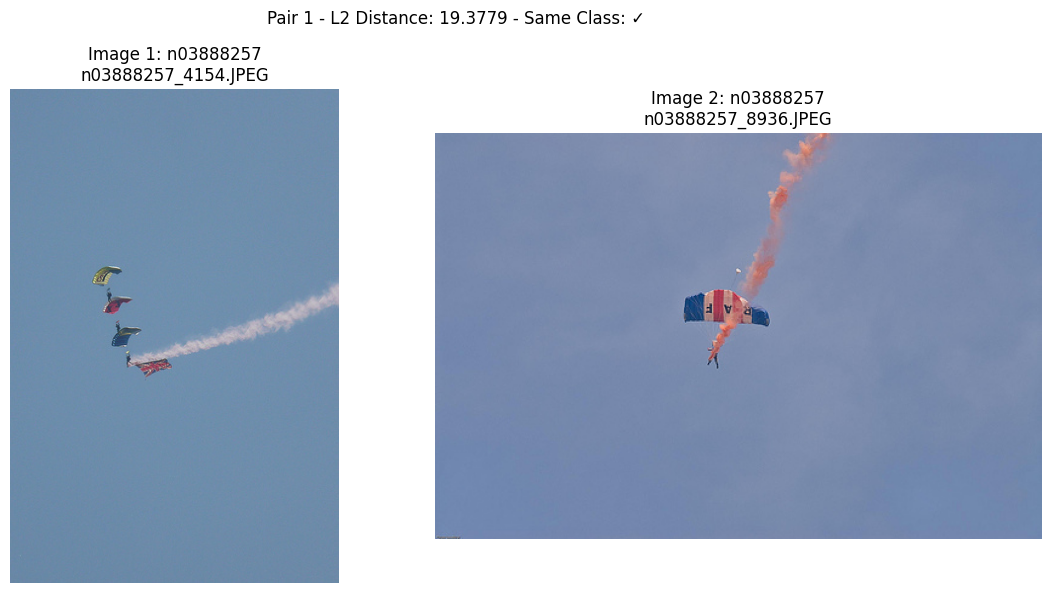

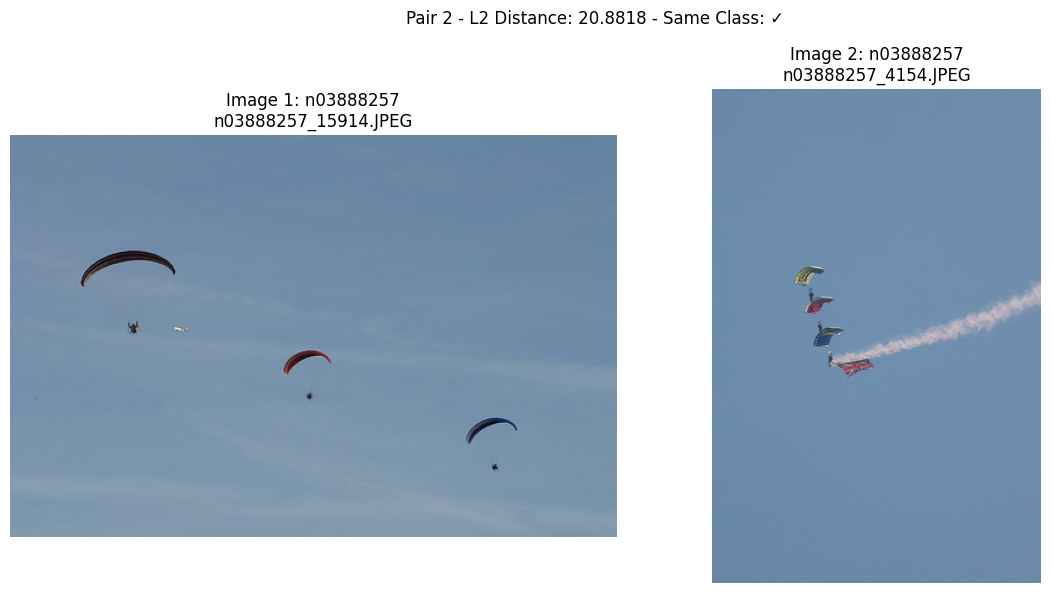

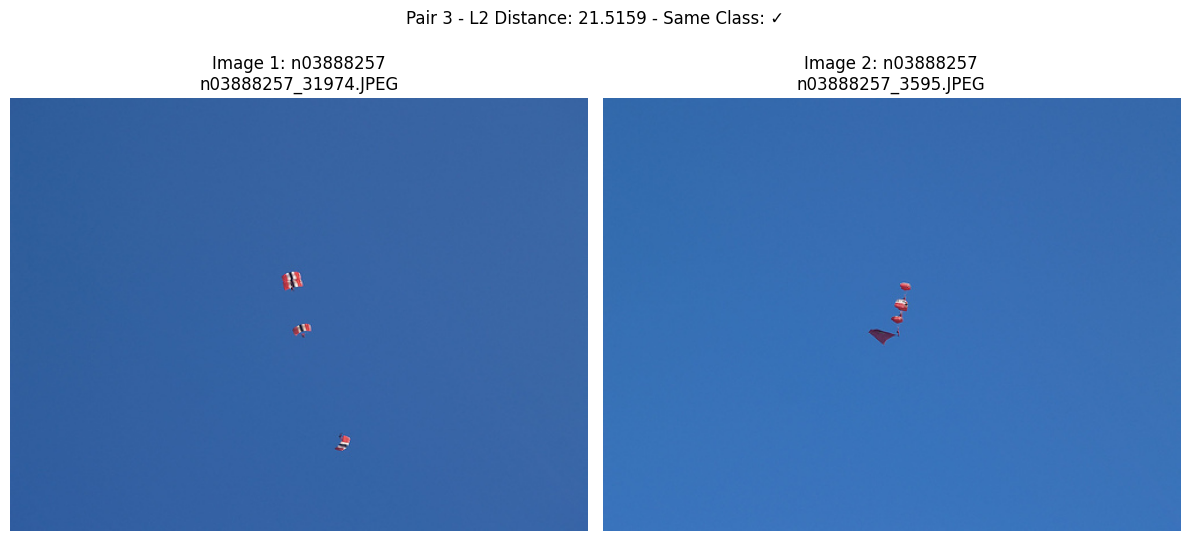

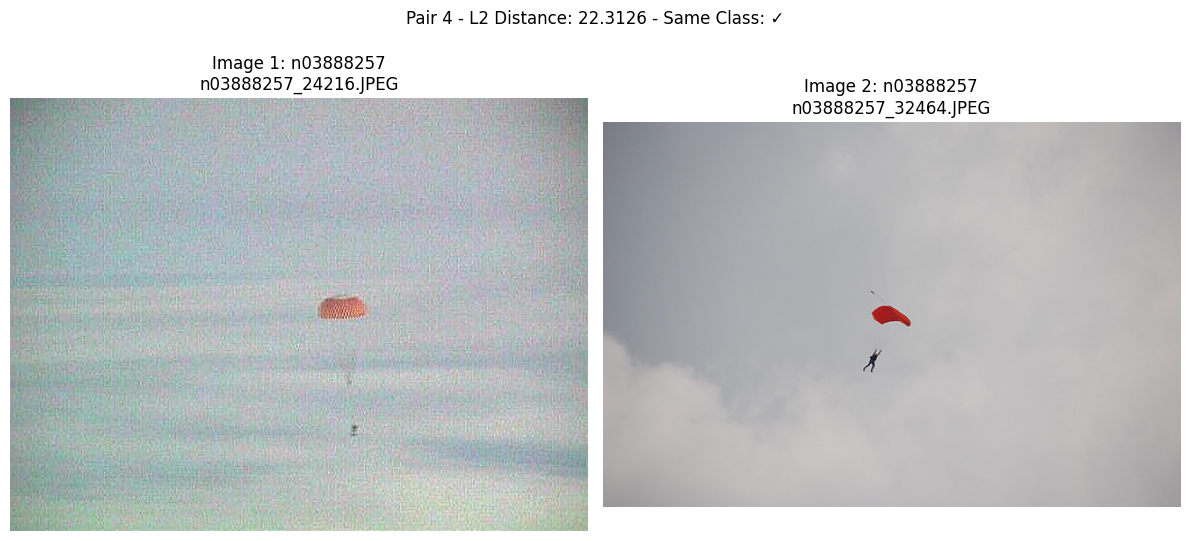

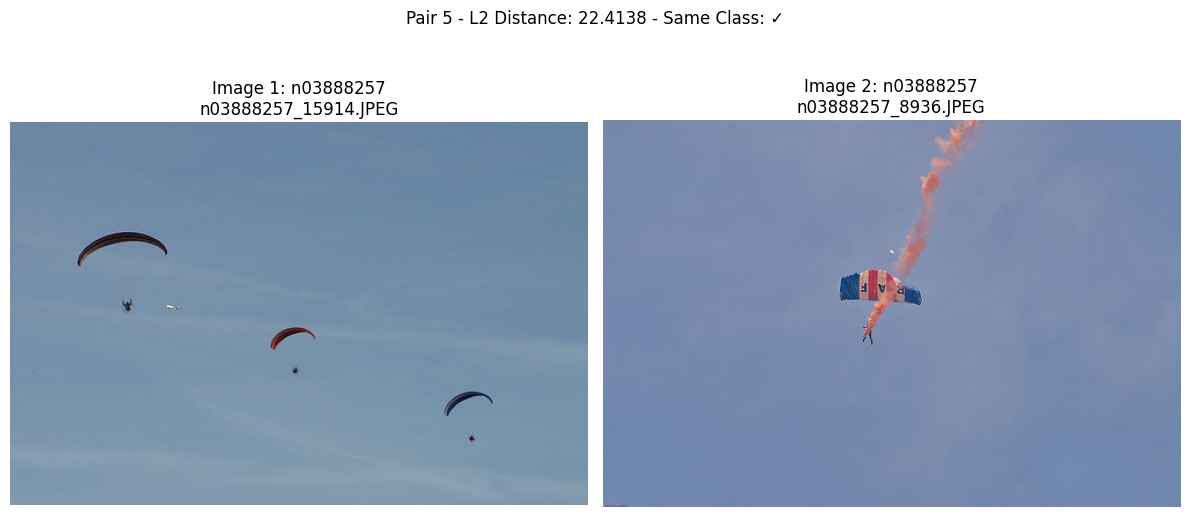

In [7]:
# Step 5: Visualize the closest pairs
print(f"Displaying top {min(CONFIG['max_display'], len(closest_pairs))} closest pairs:")
analyzer.visualize_closest_pairs(closest_pairs, max_display=CONFIG['max_display'])

# Attack the pairs of close images

In [8]:
# Add this cell after your existing cells
# Cell: Import additional libraries for collision attacks
import warnings
warnings.filterwarnings("ignore")

import json
import torch
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

try:
    import wandb
    wandb_available = True
except ImportError:
    wandb = None
    wandb_available = False

from bitstream_attack.attack import MGD, PGD, CW
from compressor import NeuralCompressor, JpegCompressor

# Disable TF32 Tensor Cores
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")

print(f"Using device: {device}")

Using device: cuda


In [9]:
def create_pair_dataset(pairs_to_attack, transform=None):
    """Convert image pairs to a torch dataset"""
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(CONFIG['image_size']),
            transforms.ToTensor(),
        ])
    
    images1 = []
    images2 = []
    
    for pair in pairs_to_attack:
        # Load and transform first image
        img1 = Image.open(pair['image1_path']).convert('RGB')
        img1_tensor = transform(img1)
        images1.append(img1_tensor)
        
        # Load and transform second image
        img2 = Image.open(pair['image2_path']).convert('RGB')
        img2_tensor = transform(img2)
        images2.append(img2_tensor)
    
    # Stack into tensors
    images1_tensor = torch.stack(images1)
    images2_tensor = torch.stack(images2)
    
    # Create dataset
    pair_dataset = TensorDataset(images1_tensor, images2_tensor)
    
    print(f"Created pair dataset with {len(pair_dataset)} image pairs")
    print(f"Image tensor shape: {images1_tensor.shape}")
    
    return pair_dataset

# Create the dataset
pair_dataset = create_pair_dataset(closest_pairs)

Created pair dataset with 10 image pairs
Image tensor shape: torch.Size([10, 3, 224, 224])


In [10]:
pair_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
config = {
        "lr": 3e-2,
        "batch_size": 8,
        "num_batches": 1,
        "num_steps": 5000,
        "image_size": 256,
        "quality_factor": 1,
        "mask_type": "dot",
        "dataset": "celeba",
        "compressor_type": "neural",
        "model_id": "my_bmshj2018_factorized_relu",
        "algorithm": "mgd",
        "mgd": {
            "vertical_skip": 2,
            "horizontal_skip": 2
        },
        "pgd": {"eta": 0.1},
        "cw": {"c": 1.0}
    }

def get_compressor(config):
    if config['compressor_type'] == 'neural':
        return NeuralCompressor(model_id=config['model_id'], quality_factor=config['quality_factor'], device=device)
    elif config['compressor_type'] == 'jpeg':
        return JpegCompressor(differentiable=True, quality_factor=config['quality_factor'], image_size=config['image_size'], device=device)
    else:
        raise ValueError("Invalid compressor type. Use 'neural' or 'jpeg'.")
    

def get_attack_algo(config, compressor):
    if config['algorithm'] == 'mgd':
        attack = MGD(model=compressor, config=config, device=device)
    elif config['algorithm'] == 'pgd':
        attack = PGD(model=compressor, config=config, device=device)
    elif config['algorithm'] == 'cw':
        attack = CW(model=compressor, config=config, device=device)
    else:
        raise ValueError("Invalid algorithm. Use 'mgd', 'pgd' or 'cw'.")
    return attack


def setup_wandb(config):
    if wandb_available:
        wandb.init(project="neural-image-compression-attack")
        wandb.config.update(config, allow_val_change=True)

compressor = get_compressor(config)
attack = get_attack_algo(config, compressor)

In [12]:
setup_wandb(config)

src, tar = pair_dataset[0]
hat = src.detach().clone()
src, hat, tar = src.to(device).unsqueeze(0).requires_grad_(True), hat.to(device).unsqueeze(0).requires_grad_(True), tar.to(device).unsqueeze(0).requires_grad_(True)
mask = attack._init_mask(hat, config['mask_type'])
x_adv, loss_tracker =  attack.attack_batch(tar, hat, mask=mask)
attack.evaluator.batch_eval(src, tar, x_adv)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jmadden (jmadden-Binghamton University). Use `wandb login --relogin` to force relogin


[Running attack]: Loss 1.8400662327167083e-08: 100%|██████████| 5000/5000 [00:43<00:00, 113.74it/s]


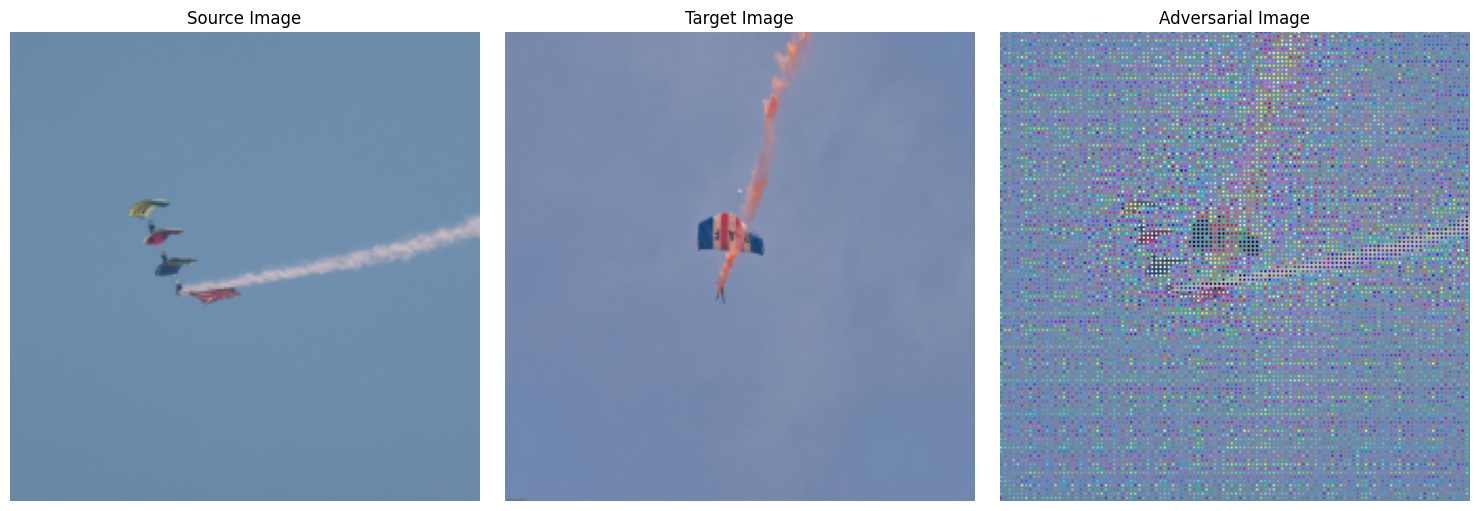

Source image shape: torch.Size([1, 3, 224, 224])
Target image shape: torch.Size([1, 3, 224, 224])
Adversarial image shape: torch.Size([1, 3, 224, 224])
Perturbation L2 norm: 54.9766


In [13]:
# Plot all 3 images side by side: source, target, and adversarial
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Convert tensors to numpy arrays and move to CPU
src_img = src.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
tar_img = tar.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
adv_img = x_adv.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()

# Clip values to [0, 1] range for display
src_img = np.clip(src_img, 0, 1)
tar_img = np.clip(tar_img, 0, 1)
adv_img = np.clip(adv_img, 0, 1)

# Plot source image
axes[0].imshow(src_img)
axes[0].set_title('Source Image')
axes[0].axis('off')

# Plot target image
axes[1].imshow(tar_img)
axes[1].set_title('Target Image')
axes[1].axis('off')

# Plot adversarial image
axes[2].imshow(adv_img)
axes[2].set_title('Adversarial Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Source image shape: {src.shape}")
print(f"Target image shape: {tar.shape}")
print(f"Adversarial image shape: {x_adv.shape}")
print(f"Perturbation L2 norm: {torch.norm(x_adv - src).item():.4f}")